In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools

In [3]:
load_file_path=os.path.join('/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/fashion', 'Copy of fashion_result.csv')
print(load_file_path)

save_folder='/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/fashion'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/fashion/Copy of fashion_result.csv


In [4]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [5]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
    df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df

# Example usage:
flops_dict = {"conv1x1FLOPS": 0.012544, "conv1x1_3x3FLOPS": 0.909, "conv1x1_5x5FLOPS": 2.515, "totalFLOPS": 13.274}
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [6]:
def normalize_feature_attribution_final(df):
    """
    Final modification of the normalization of feature attributions for each layer.

    Parameters:
    df (DataFrame): The dataframe containing the feature attributions.

    Returns:
    DataFrame: A modified dataframe with normalized feature attributions for each layer.
    """
    # Columns to be normalized
    layers = ['conv1x1', 'conv1x1_3x3', 'conv1x1_5x5']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    df.drop(['sum_feature_attr','conv1x1',	'conv1x1_3x3',	'conv1x1_5x5'], axis=1, inplace=True)

    return df

# Example usage of the final modified function
normalized_final_df = normalize_feature_attribution_final(df.copy())

get average and normalzied variance for each combination of hyperparameter

In [7]:
def calculate_normalized_variance(df, method, flops_dict):
    """
    Modified combined function to calculate the average and normalized variance of each layer's feature attribution
    for a given method, including both average and variance in one dataframe, along with average accuracy after each epoch.
    This version also includes FLOPS information.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    method (str): The method to filter the data ('deeplift' or 'integrated_gradients').
    flops_dict (dict): Dictionary containing FLOPS values for different layers.

    Returns:
    DataFrame: A dataframe with the average and normalized variance for each layer combined, and average accuracy after each epoch, including FLOPS info.
    """
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_conv1x1', 'norm_conv1x1_3x3', 'norm_conv1x1_5x5']
    accuracy_columns = ['train accuracy epoch0', 'test accuracy epoch0']

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var_norm = grouped[layers].var()
    avg_acc = grouped[accuracy_columns].mean()

    # Calculate normalized variance (variance/mean)
    norm_var = var_norm / avg_norm

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'norm_var_{layer}'] = norm_var[layer]

    # Calculate the average normalized variance across the selected layers
    norm_var_layers = [f'norm_var_{layer}' for layer in layers]
    combined_df['avg_normalized_variance'] = combined_df[norm_var_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
combined_avg_norm_var_acc_deeplift = calculate_normalized_variance(normalized_final_df, 'deeplift', flops_dict)
combined_avg_norm_var_acc_integrated_gradients = calculate_normalized_variance(normalized_final_df, 'integrated_gradients', flops_dict)

In [8]:
combined_avg_norm_var_acc_deeplift.to_csv(save_folder+"/mnist dl.csv")
combined_avg_norm_var_acc_deeplift=pd.read_csv(save_folder+"/mnist dl.csv")

In [9]:
def filter_by_accuracy(df, threshold=70.0):
    """
    Function to filter out rows where the average accuracy across epoch 3 (both train and test) is lower than a specified threshold.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    threshold (float): The threshold for average accuracy in epoch 3.

    Returns:
    DataFrame: A filtered dataframe with rows having average epoch 3 accuracy higher than the threshold.
    """
    # Columns representing epoch 3 accuracy
    epoch_3_accuracy_cols = ['train accuracy epoch0', 'test accuracy epoch0']

    # Calculate the average accuracy for epoch 3
    df['avg_accuracy_epoch_3'] = df[epoch_3_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['avg_accuracy_epoch_3'] >= threshold]

    return filtered_df

# Apply the function to the dataframes for 'deeplift' and 'integrated_gradients'
filtered_deeplift = filter_by_accuracy(combined_avg_norm_var_acc_deeplift)
filtered_integrated_gradients = filter_by_accuracy(combined_avg_norm_var_acc_integrated_gradients)

# Display the first few rows of the filtered dataframes
filtered_deeplift


,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_conv1x1,norm_conv1x1_3x3,norm_conv1x1_5x5,norm_var_norm_conv1x1,norm_var_norm_conv1x1_3x3,norm_var_norm_conv1x1_5x5,avg_normalized_variance,train accuracy epoch0,test accuracy epoch0,conv1x1FLOPS,conv1x1_3x3FLOPS,conv1x1_5x5FLOPS,totalFLOPS,avg_accuracy_epoch_3
0,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),0.5,False,16,0.493408,0.248777,0.257815,0.010103,0.066468,0.062688,0.046420,82.227500,84.500000,0.012544,0.909,2.515,13.274,83.363750
1,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),0.5,False,32,0.497540,0.263104,0.239356,0.006838,0.045702,0.050434,0.034325,82.343167,84.498000,0.012544,0.909,2.515,13.274,83.420583
2,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),0.5,False,64,0.525181,0.258947,0.215873,0.009948,0.024697,0.025161,0.019935,81.871500,84.328000,0.012544,0.909,2.515,13.274,83.099750
3,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),0.5,True,16,0.481733,0.263734,0.254533,0.003634,0.070649,0.061161,0.045148,82.264333,83.887000,0.012544,0.909,2.515,13.274,83.075667
4,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),0.5,True,32,0.465262,0.255031,0.279707,0.010492,0.056677,0.057184,0.041451,82.451167,84.739000,0.012544,0.909,2.515,13.274,83.595083
5,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),0.5,True,64,0.513191,0.251614,0.235194,0.011517,0.026676,0.042636,0.026943,82.112000,84.414000,0.012544,0.909,2.515,13.274,83.263000
6,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1.0,False,16,0.492971,0.251513,0.255516,0.010304,0.074464,0.065054,0.049941,82.238667,84.403000,0.012544,0.909,2.515,13.274,83.320833
7,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1.0,False,32,0.500999,0.261885,0.237117,0.006938,0.046124,0.050685,0.034582,82.351667,84.502000,0.012544,0.909,2.515,13.274,83.426833
8,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1.0,False,64,0.524327,0.259729,0.215945,0.010551,0.025565,0.026572,0.020896,81.863500,84.396000,0.012544,0.909,2.515,13.274,83.129750
9,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1.0,True,16,0.480355,0.260501,0.259143,0.002850,0.074260,0.064070,0.047060,82.296500,83.834000,0.012544,0.909,2.515,13.274,83.065250


# Graph

In [10]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    """
    Plots bar graphs of the average variance of each layer and the overall average variance
    for multiple values of a given hyperparameter.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    hyperparam (str): The hyperparameter to vary.
    variables (list): A list of values for the hyperparameter to compare.

    Returns:
    None: The function plots graphs directly.
    """
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'norm_var' in col]
    variance_columns.append('avg_normalized_variance')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


In [11]:
filtered_deeplift.to_csv(save_folder+"/mnsit dl ave var.csv")

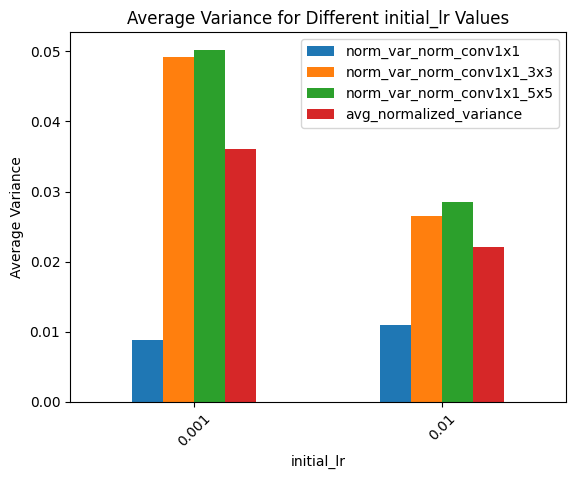

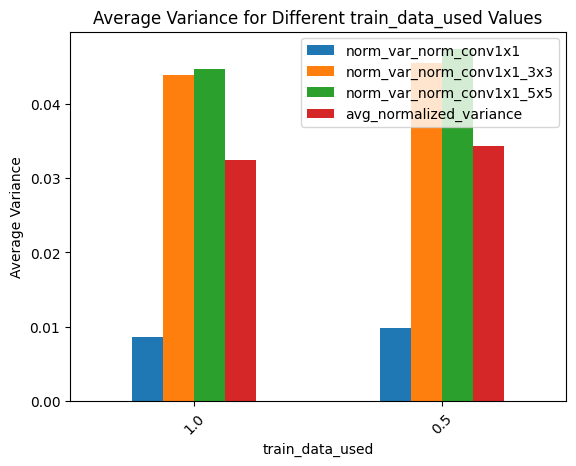

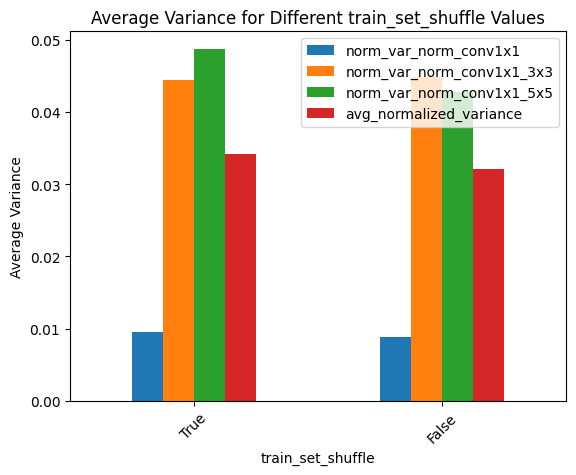

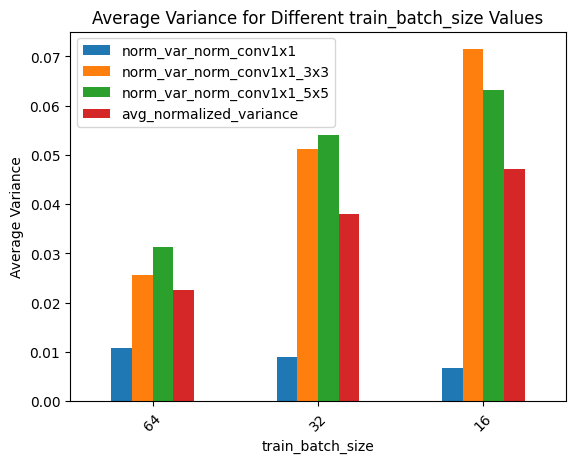

In [12]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.01],
    'train_data_used': [1, 0.5],
    'train_set_shuffle': [True,False],
    'train_batch_size': [64, 32, 16]
}

for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(filtered_deeplift, hyperparam, variables)

# T test

In [13]:
def perform_t_test(df, target_column, condition_column, choice1, choice2):
    # Splitting the data into two groups based on the condition
    group1 = df[df[condition_column] == choice1][target_column]
    group2 = df[df[condition_column] == choice2][target_column]

    # Performing the independent t-test
    t_statistic, p_value = ttest_ind(group1, group2)

    return t_statistic, p_value

In [14]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_data_used', 1, 0.5)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -0.3086589740072491 P-value: 0.7624715886630842


In [15]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'initial_lr', 0.01, 0.001)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -2.1726326423239306 P-value: 0.04889056057436847


In [16]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_set_shuffle', True, False)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.3454931247760132 P-value: 0.7352502432186645


In [17]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 64, 32)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -7.201198321003444 P-value: 5.0766064838206576e-05


In [18]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 64, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -14.374653710667703 P-value: 1.6320195666906818e-07


In [19]:
result = perform_t_test(filtered_deeplift, 'avg_normalized_variance', 'train_batch_size', 32, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -3.990425890650385 P-value: 0.007197091025696337


# Paired T test

In [20]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [21]:
def generate_hyperparameter_combinations(hyperparams):
    """
    Generate a sequence of hyperparameter combinations.

    :param hyperparams: A dictionary where keys are the names of hyperparameters,
                        and values are lists of possible choices for each hyperparameter.
    :return: A list of dictionaries, each representing a unique combination of hyperparameters.
    """
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [22]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

train_data_used

In [23]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, target_column='avg_normalized_variance', condition_column='train_data_used', choice1=1, choice2=0.5)
t_statistic, p_value = ttest_rel(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "P-value:", p_value)

0.0242734876200788 0.0269431327229638
0.0416687853449433 0.0414507884634338
0.047059955704811 0.0451479562651396
0.0208960302185707 0.0199349881169904
0.0345824565291914 0.0343247131056876
0.0499407099330334 0.0464197484791867
0.0217443053128146 0.0254418871328933
T-statistic: 0.07561775011055459 P-value: 0.942181491536871


initial_lr

In [24]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.01, 0.001)
t_statistic, p_value = ttest_rel(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "P-value:", p_value)

0.0217443053128146 0.0242734876200788
0.0188510253986491 0.0208960302185707
0.0254418871328933 0.0269431327229638
T-statistic: -6.820828996768444 P-value: 0.02082532986036868


train_set_shuffle

In [25]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_set_shuffle', True, False)
t_statistic, p_value = ttest_rel(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "P-value:", p_value)

0.0242734876200788 0.0208960302185707
0.0416687853449433 0.0345824565291914
0.047059955704811 0.0499407099330334
0.0269431327229638 0.0199349881169904
0.0414507884634338 0.0343247131056876
0.0451479562651396 0.0464197484791867
0.0217443053128146 0.0188510253986491
T-statistic: 2.1395451752163908 P-value: 0.07619821341761451


train_batch_size

In [26]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 64, 32)
t_statistic, p_value = ttest_rel(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "P-value:", p_value)

0.0242734876200788 0.0416687853449433
0.0208960302185707 0.0345824565291914
0.0269431327229638 0.0414507884634338
0.0199349881169904 0.0343247131056876
T-statistic: -18.276285131185485 P-value: 0.00035739294362755657


In [27]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 64, 16)
t_statistic, p_value = ttest_rel(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "P-value:", p_value)

0.0242734876200788 0.047059955704811
0.0208960302185707 0.0499407099330334
0.0269431327229638 0.0451479562651396
0.0199349881169904 0.0464197484791867
T-statistic: -10.241787486676088 P-value: 0.001984429481719531


In [28]:
data_pairs=get_all_pairs(filtered_deeplift, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 32, 16)
t_statistic, p_value = ttest_rel(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "P-value:", p_value)

0.0416687853449433 0.047059955704811
0.0345824565291914 0.0499407099330334
0.0414507884634338 0.0451479562651396
0.0343247131056876 0.0464197484791867
T-statistic: -3.3159977082020107 P-value: 0.045189009176744295
